# NLP Disaster Tweets Kaggle Mini-Project

## Imports and configs

In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPool1D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

nltk.download('stopwords')
nltk.download('punkt')

BASE_PATH = "data"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielandriotti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gabrielandriotti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Brief description of the problem and data

The goal of this project is to build a machine learning model that predicts disasters using Tweets. The idea to approach this problem is to train a Recurrent Neural Network (RNN) with Keras to predict disaster based on the input text (tweets). This dataset was created by the company figure-eight and originally shared on their *Data For Everyone* website.

### Train data

**7613** tweets identified by an **id** and labeled with **0 (no disaster)** or **1 (disaster)** in the column **target**

In [2]:
df_raw = pd.read_csv(f"{BASE_PATH}/train.csv")[["id","text","target"]]
print("Tweets: ", df_raw.shape[0])
df_raw.head()

Tweets:  7613


,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


### Test data

**3263** tweets identified by an **id**

In [3]:
df_test = pd.read_csv(f"{BASE_PATH}/test.csv")[["id","text"]]
print("Tweets: ", df_test.shape[0])
df_test.head()

Tweets:  3263


,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis (EDA)

As the data doesn't have missing values, the only cleaning procedure that I will apply is resampling the data in order to have the same amount of tweets for both targets (0 and 1). As the the target 0 has more tweets, I will downsample it to equalize them. Below I also show a sample of tweets from both targets to get a sense of their differences.

In [4]:
df_raw.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


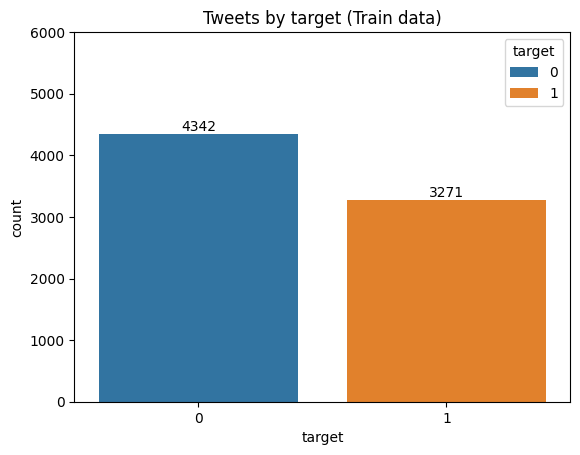

In [6]:
ax = sns.countplot(df_raw, x="target", hue="target")
ax.set_title("Tweets by target (Train data)")
plt.ylim(0, 6000)
for i in ax.containers:
    ax.bar_label(i)

### Sample of tweets (disaster)

In [127]:
for tweet in df_raw.query("target == 1").text.sample(15):
    print(tweet) 

Still can't get over the thunderstorm/tornado we were woken up to yesterday. Half the street is still in the dark! http://t.co/Y8h5v1j2y7
Perhaps 'historic' should be applied not to the deluge of recently exposed #ChildSexAbuse but the truly 'historic' scale of the cover-up
Afghanistan: sharp rise in women and children casualties in first half of 2015 http://t.co/3sqSErgnI2
Holy moly that was crushed.
TV: Vitaly Churkin Briliantly Exposes the Hypocrisy of the Ukraine's FM Klimkin About the MH17 Disaster http://t.co/tt4kVmvuJq
@samanthaturne19 IIt may logically have been the right call... maybe... But it's an act of mass murder and I can't sanction it.
Sioux City Fire Officials Believe Bridge Collapse Lead To Cement Truck Roll Over - Siouxland Matters: Siouxlan... http://t.co/sZTGmbkoHG
Dry thunderstorms with lightning possible in the Pinpoint Valley Forecast. http://t.co/IdASYJybrO http://t.co/gdoAOLPq91
70th anniversary of Hiroshima atomic bombing marked  http://t.co/1mGvd4x5Oe
USGS E

### Sample of tweets (no disaster)

In [128]:
for tweet in df_raw.query("target == 0").text.sample(15):
    print(tweet) 

What a goooooooaaaaaal!!!!!!
Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/x8moYeVjsJ
@Im2aD I was going to tell him but you were body bagging him
So happy to be exercised of the demon of @ATT. Price kept rising service kept sinking. #goodbye
Angry Mistrustful Rescued Elephant Finds Peace and Friendship in Her New Home (PHOTOS) http://t.co/VaUnPS6WJa via @OneGreenPlanet
@chaosmagician97 awesome!! I saw he was bleeding pretty bad
i s2g if anyone tries to harm my cupcake i'll fucking hunt you down to the end of the earth #HarryBeCareful
Reusing advanced in life equipments in transit to drumming champaign damage: FdbDP
2pcs 18W CREE Led Work Light  Offroad Lamp Car Truck Boat Mining 4WD FLOOD BEAM - Full reaÛ_ http://t.co/O1SMUh2unn http://t.co/xqj6WgiuQH
@NicolaClements4 IÛªm not sure that covering my head in wounds and scabs is the solution ;)
Clev: Me? | You. Clev: Indeed. | Do you know what happened to b

### Plan of approach to solve the problem

The plan is to train a Recurrent Neural Network (RNN) with Keras to predict disasters based on the input text. Initially I will clean the tweets and then resample the data keeping 3271 tweets for each target (0 or 1). And then I will split the data in train and validation sets to use at training the model and evaluating the results. After that I will apply tokenization and padding to the data in order to prepare for training a LSTM.

### Preprocessing data

The functions below were created by https://www.kaggle.com/tanulsingh077

In [9]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

def preprocess_data(text):
    stop_words = stopwords.words('english') + ['u', 'im', 'c']
    stemmer = nltk.SnowballStemmer("english")
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)
    return text


df_test['text_clean'] = df_test['text'].apply(preprocess_data)
df_raw['text_clean'] = df_raw['text'].apply(preprocess_data)

In [10]:
SAMPLE_SIZE = 3271

df = df_raw.groupby('target').sample(SAMPLE_SIZE)

X_train, X_val, y_train, y_val = train_test_split(df.text_clean, df.target, test_size=0.2)

In [98]:
# Parameters
max_words = 13000 # Vocabulary size
max_len = 25 # Max tweet length (considering tokens, not characters)
embedding_dim = 32

# Tokenization and padding
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

## Model Architecture

### Model 1

A initial Recurrent Neural Network (more specifically a LSTM) architecture for a binary classification problem to have a baseline for further improvements.

Layers:
- Embedding
- LSTM
- Dense

To process the text to matrix form (word embedding), I chose the approach of tokenizing and padding the tweets following these steps:

- Tokenize the text to convert it to sequences of integers
- Pad the sequences to ensure they are of uniform length
- Feed these sequences into an embedding layer within the neural network (the embedding layer will then learn the word embeddings during the training process)

In [99]:
# Build the model
model1 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

# Compile the model
model1.compile(Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [100]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
h1 = model1.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5087 - loss: 0.6931 - val_accuracy: 0.4622 - val_loss: 0.6944
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5006 - loss: 0.6931 - val_accuracy: 0.4622 - val_loss: 0.6942
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5662 - loss: 0.6845 - val_accuracy: 0.7922 - val_loss: 0.4710
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8312 - loss: 0.4003 - val_accuracy: 0.8060 - val_loss: 0.4489
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8864 - loss: 0.3023 - val_accuracy: 0.7945 - val_loss: 0.4755
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9063 - loss: 0.2518 - val_accuracy: 0.7953 - val_loss: 0.5194
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9338 - loss: 0.2024 - val_accuracy: 0.7930 - val_loss: 0.5631


In [129]:
model1.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ (None, 25, 32)         │       416,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,273,061 (4.86 MB)

 Trainable params: 424,353 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 848,708 (3.24 MB)

### Model 2

Model 1 architecture added with regularizers to mitigate overfitting.

Layers:
- Embedding
- LSTM (with L2 regularizers)
- Dense

In [114]:
# Build the model
model2 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(32, kernel_regularizer=l2(0.3), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.2), activity_regularizer=l2(0.1)),  
    Dense(1, activation='sigmoid')
])

# Compile the model
model2.compile(Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [115]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
h2 = model2.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5051 - loss: 21.2895 - val_accuracy: 0.4622 - val_loss: 18.5878
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5068 - loss: 17.8108 - val_accuracy: 0.4622 - val_loss: 15.6645
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5094 - loss: 15.0438 - val_accuracy: 0.4622 - val_loss: 13.3280
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5116 - loss: 12.8314 - val_accuracy: 0.4622 - val_loss: 11.4587
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5277 - loss: 11.0610 - val_accuracy: 0.4622 - val_loss: 9.9631
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5165 - loss: 9.6452 - val_accuracy: 0.4622 - val_loss: 8.7681
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5040 - loss: 8.5140 - val_accuracy: 0.4622 - val_loss: 7.8138
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5100 - loss: 7.6103 -

In [130]:
model2.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_42 (Embedding)        │ (None, 25, 32)         │       416,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,273,061 (4.86 MB)

 Trainable params: 424,353 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 848,708 (3.24 MB)

## Results and Analysis

About training the models, I chose an approach of starting with a LSTM model without using dropouts or regularizers to get a sense of the accuracy the model could reach. Then I created a new model with regularizers to avoid overfitting. After testing different parameters, I could find a better balance between train and validation metrics. I chose to not use dropouts because the Keras implementation of LSTM is way slower when adding dropouts.

Below there are some plots with the training history of the models with the metrics for both train and validation data:

In [118]:
def show_model_history(h, model):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(f"Model {model} training history", fontsize=13, fontweight='bold')
    axs[0].plot(h.history['accuracy'], label='train')
    axs[0].plot(h.history['val_accuracy'], label='validation')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(loc='upper left')
    axs[1].plot(h.history['loss'], label='train')
    axs[1].plot(h.history['val_loss'], label='validation')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(loc='upper left')

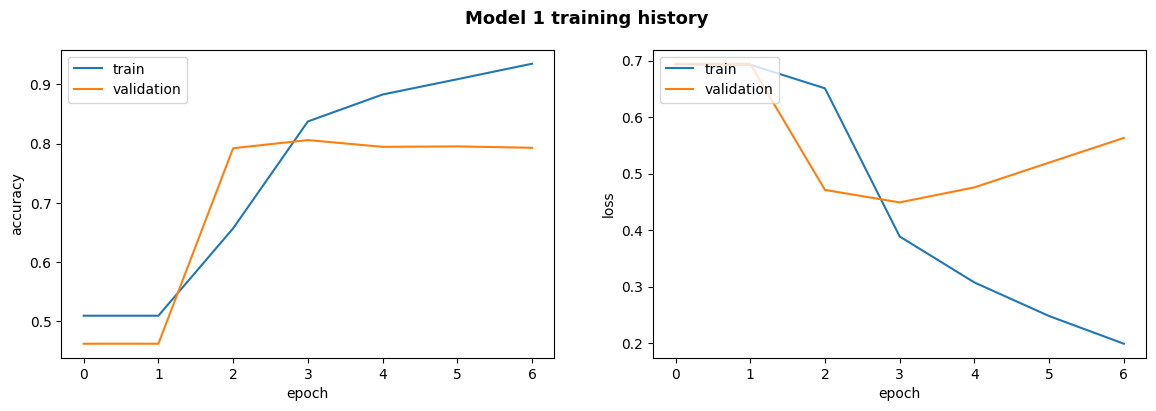

In [131]:
show_model_history(h1, "1")

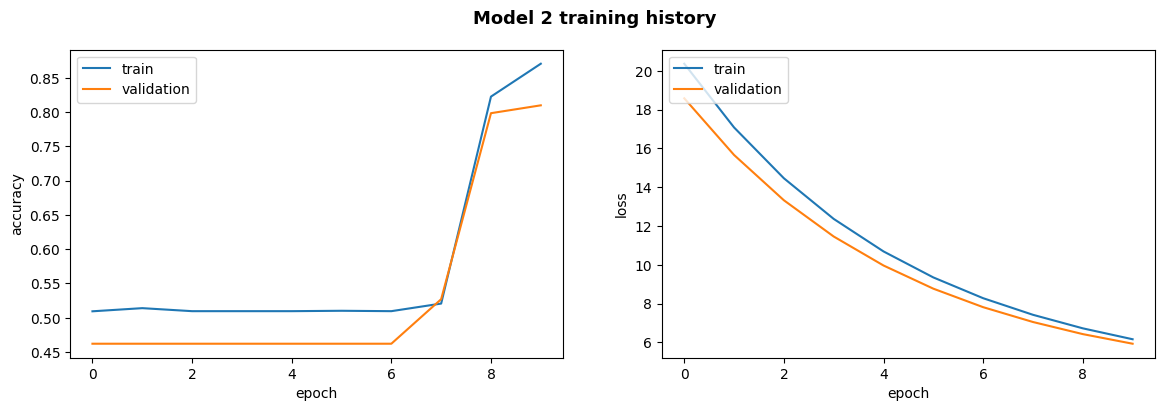

In [132]:
show_model_history(h2, "2")

### Validation data results of the best model

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


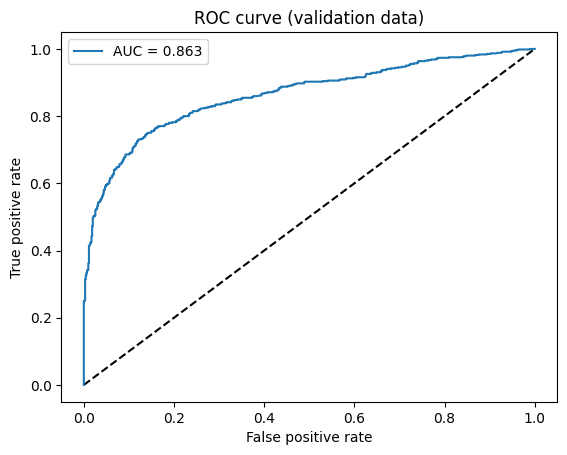

In [121]:
y_pred = model2.predict(X_val_pad)
y_true = y_val

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve (validation data)")
plt.legend(loc="best")
plt.show()

### Test data predictions with the best model

In [125]:
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(df_test.text_clean), maxlen=max_len, padding='post')
df_test['target'] = (model2.predict(X_test_pad) > 0.5).astype("int32")
submission = df_test[['id','target']]
print(submission.head(10))
submission.to_csv("submission.csv", index = False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
5  12       1
6  21       0
7  22       0
8  27       0
9  29       0


## Conclusion

After testing different parameters and architectures, LSTM seemed to be a good enough fit for this data and problem. So I ended up using this approach and playing around with different ways to regularize the overfitting. One lesson learned is that text classification problems can easily overfit, so it's very important to pay attention to using methods to avoid this behavior. Another thing learned is that for a LSTM, increasing the units of the layer didn't help much. A small number could already bring a very good performance.
As next steps, I wanted to not downsampling the data with target 0 but instead running a training that considers the classes and balance them. 